# Practical 4: DynamicProgramming

In [1]:
import numpy as np
import rldurham as rld

In [2]:
name = 'FrozenLake-v1'  # small version
# name = 'FrozenLake8x8-v1'  # larger version
env = rld.make(name, is_slippery=False)
rld.seed_everything(42, env)
LEFT, DOWN, RIGHT, UP = 0, 1, 2, 3

Seed set to 42


action space: Discrete(4)
reward range: (0, 1)
observation space: Discrete(16)


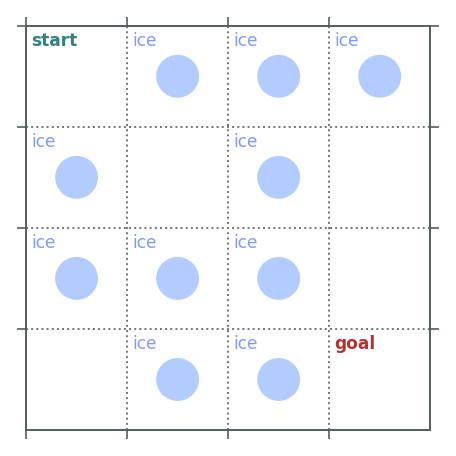

In [3]:
print('action space: ' + str(env.action_space))
print('reward range: ' + str(env.reward_range))
print('observation space: ' + str(env.observation_space))
rld.plot_frozenlake(env=env)

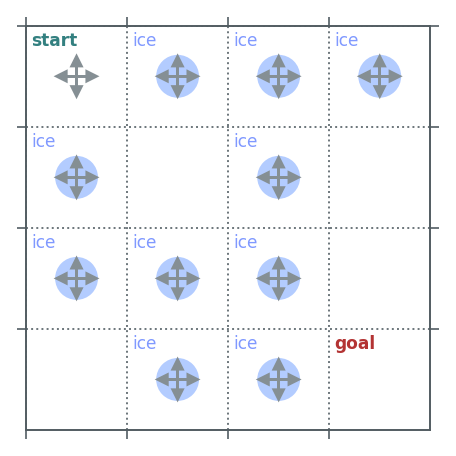

In [4]:
def uniform_policy(env):
    return np.ones((env.observation_space.n, env.action_space.n)) / env.action_space.n
rld.plot_frozenlake(env=env, policy=uniform_policy(env))

In [5]:
def policy_eval_step(env, policy, gamma, v_init=None):
    if v_init is None:
        v_init = np.zeros(env.observation_space.n)
    v = np.zeros(env.observation_space.n)
    for s_from in range(env.observation_space.n):
        for a in range(env.action_space.n):
            pi = policy[s_from, a]
            for p, s_to, r, done in env.P[s_from][a]:
                v[s_from] += pi * p * (r + gamma * v_init[s_to])
    return v

In [6]:
v = np.zeros(env.observation_space.n)

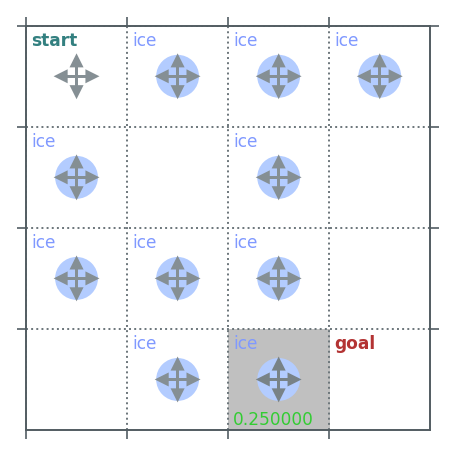

In [7]:
v = policy_eval_step(env, uniform_policy(env), 1, v)
rld.plot_frozenlake(env, v, uniform_policy(env), draw_vals=True)

In [8]:
def policy_eval_step_inplace(env, policy, gamma, v_init=None):
    if v_init is None:
        v_init = np.zeros(env.observation_space.n)
    v = v_init.copy() # opearate on copy in-place
    for s_from in reversed(range(env.observation_space.n)):  # reverse order of states
        v_s_from = 0  # compute value for this state
        for a in range(env.action_space.n):
            pi = policy[s_from, a]
            for p, s_to, r, done in env.P[s_from][a]:
                v_s_from += pi * p * (r + gamma * v[s_to])  # use the values we also update
        v[s_from] = v_s_from  # update
    return v

In [9]:
def policy_evaluation(env, policy, gamma, v_init=None,
                      print_iter=False, atol=1e-8, max_iter=10**10):
    if v_init is None:
        v_init = np.zeros(env.observation_space.n)
    v = v_init
    for i in range(1, max_iter + 1):
        new_v = policy_eval_step(env, policy, gamma, v)
        if np.allclose(v, new_v, atol=atol):
            break
        v = new_v
    if print_iter:
        print(f"{i} iterations")
    return v

In [10]:
def q_from_v(env, v, s, gamma):
    q = np.zeros(env.action_space.n)
    for a in range(env.action_space.n):
        for p, s_to, r, done in env.P[s][a]:
            q[a] += p * (r + gamma * v[s_to])
    return q

In [11]:
def policy_improvement(env, v, gamma, deterministic=False):
    policy = np.zeros([env.observation_space.n, env.action_space.n]) / env.action_space.n
    for s in range(env.observation_space.n):
        q = q_from_v(env, v, s, gamma)
        if deterministic:
            # deterministic policy
            policy[s][np.argmax(q)] = 1
        else:
            # stochastic policy with equal probability on maximizing actions
            best_a = np.argwhere(q==np.max(q)).flatten()
            policy[s, best_a] = 1 / len(best_a)
    return policy

Seed set to 42


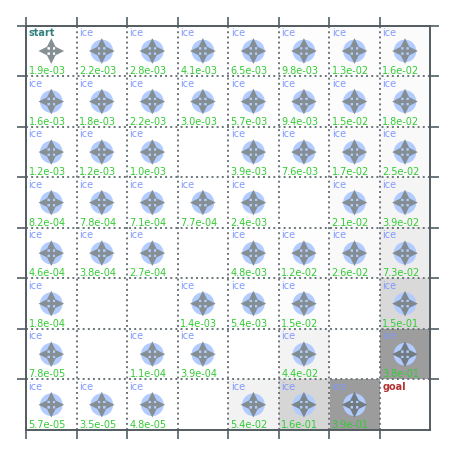

In [12]:
env = rld.make('FrozenLake8x8-v1', is_slippery=False)
rld.seed_everything(42, env)
policy = uniform_policy(env)
v = policy_evaluation(env, policy, gamma=1)
rld.plot_frozenlake(env, v, policy, draw_vals=True)

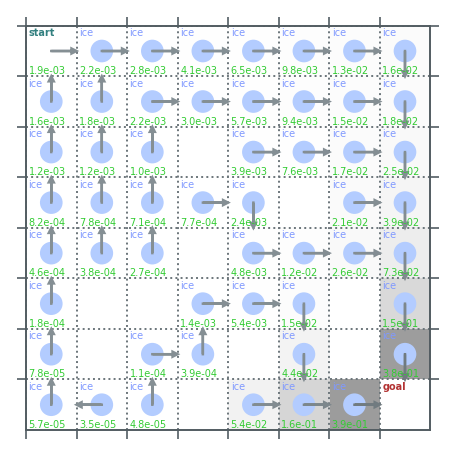

In [13]:
new_policy = policy_improvement(env, v, gamma=1)
rld.plot_frozenlake(env, v, new_policy, draw_vals=True)

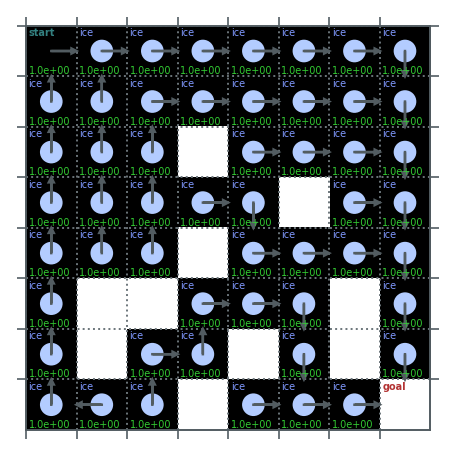

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1.
 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0.]


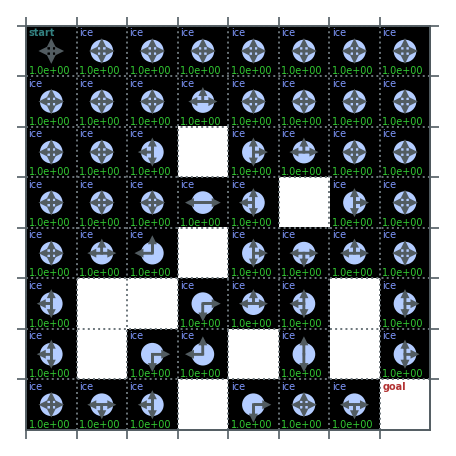

In [14]:
gamma = 1
v = policy_evaluation(env, new_policy, gamma=gamma)
rld.plot_frozenlake(env, v=v, policy=new_policy, draw_vals=True)
print(v)
new_policy = policy_improvement(env, v, gamma=gamma)
rld.plot_frozenlake(env, v=v, policy=new_policy, draw_vals=True)